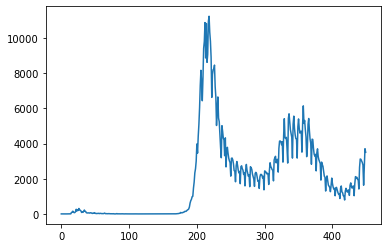

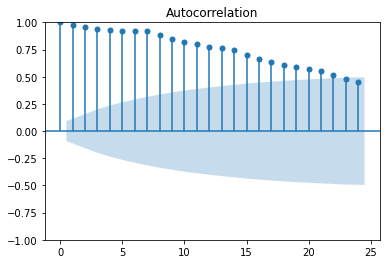

C:\Users\Todd\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


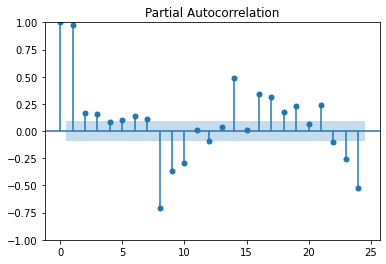

In [1]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from tensorflow import keras
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import SimpleRNN
from tensorflow.keras.layers import LeakyReLU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# LSTM with regression framing
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from keras import optimizers
dataset = pandas.read_csv(r'D:\專題\各縣市每日確診資料\台北市每日確診數.csv', usecols=[2], engine='python', skipfooter=3,encoding='utf-8')
plt.plot(dataset)
plt.savefig('Taipei.png')
plt.show()

# 畫出 ACF 12 期的效應
sm.graphics.tsa.plot_acf(dataset, lags=24)
plt.savefig('Taipei_acf_24.png')
plt.show()
# 畫出 PACF 12 期的效應
sm.graphics.tsa.plot_pacf(dataset, lags=24)
plt.savefig('Taipei_pacf_24.png')
plt.show()

In [2]:
# 產生 (X, Y) 資料集, Y 是下一期的感染人數
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

# 載入訓練資料
dataframe = read_csv(r'D:\專題\各縣市每日確診資料\台北市每日確診數.csv', usecols=[2], engine='python', skipfooter=0,encoding='utf-8')
dataframe=dataframe.drop(dataframe[dataframe['確定病例數']==0].index,axis=0)
print(dataframe)
#plt.plot(dataframe)

dataset = dataframe.values
print(len(dataset))
#dataset=np.delete(dataset,[0,768],axis=0)

# 正規化(normalize) 資料，使資料值介於[0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

     確定病例數
0        2
1        1
2        1
3        1
4        1
..     ...
446   1635
447   2734
448   3710
449   3508
450   2865

[451 rows x 1 columns]
451


## RNN結合GRU架構

### Model1

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 64)             16896     
                                                                 
 gru (GRU)                   (None, 64)                24960     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 41,921
Trainable params: 41,921
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
41/41 [==============================] - 9s 54ms/step - loss: 0.0601 - mse: 0.0601 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 2/100
41/41 [==============================] - 0s 10ms/step - loss: 0.0463 - mse: 0.0463 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 3/100
41/41 [==============================] -

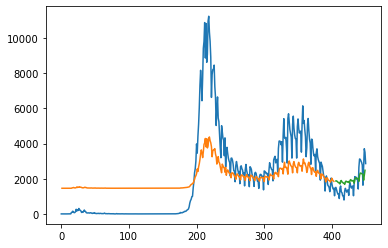

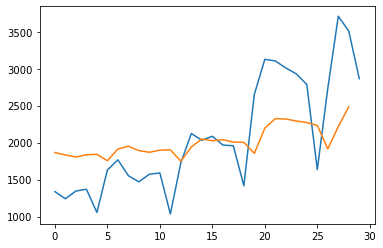

In [3]:
tf.random.set_seed(7)

# 2/3 資料為訓練資料， 1/3 資料為測試資料
train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# 產生 (X, Y) 資料集, Y 是下一期的確診數(reshape into X=t and Y=t+1)
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# 建立及訓練 GRU 模型
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(1, look_back)),
    GRU(64, activation='tanh'),
    Dense(1, activation='tanh')
])

#model.compile(loss='categorical_crossentropy', optimizer=opt)
#opt = keras.optimizers.Adam(learning_rate=0.0001)
sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd ,metrics=['mse'])


model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="taipei_gru_lstm.keras",
    save_weights_only=True,
    monitor='val_mse',
    mode='min',
    save_best_only=True)

model.summary()
history = model.fit(trainX, trainY,validation_data=(testX, testY), epochs=100, batch_size=10, verbose=1,callbacks=[model_checkpoint_callback])
model.save('taipei.h5')
# 預測
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# 回復預測資料值為原始數據的規模
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
#看裡面的值是否合理、資料結構的dim
print(trainPredict,trainY)
print(testPredict,testY)

# calculate 均方根誤差(root mean squared error)
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

#model = keras.models.load_model("jena_lstm.keras")
#print(f"Test MAE: {model.evaluate(testPredict)[1]:.2f}")

# 畫訓練資料趨勢圖
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# 畫測試資料趨勢圖
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


# 畫原始資料趨勢圖8
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.savefig('Taipei_plot.png') 
plt.show()
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
days=len(testPredictPlot)
plt.plot(scaler.inverse_transform(dataset[days-30:,:]))
plt.plot(testPredictPlot[days-30:,:])
plt.savefig("taipei_predict&real.png")
plt.show()

### Model2

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 1, 128)            66560     
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 165,761
Trainable params: 165,761
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
41/41 [==============================] - 8s 48ms/step - loss: 0.0625 - mse: 0.0625 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 2/100
41/41 [==============================] - 0s 12ms/step - loss: 0.0480 - mse: 0.0480 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 3/100
41/41 [=============================

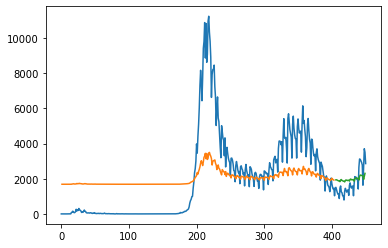

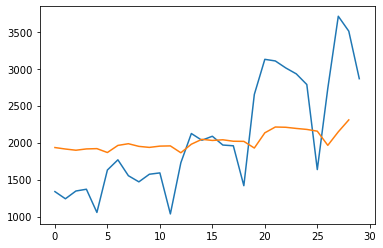

In [4]:
tf.random.set_seed(7)

# 2/3 資料為訓練資料， 1/3 資料為測試資料
train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# 產生 (X, Y) 資料集, Y 是下一期的確診數(reshape into X=t and Y=t+1)
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# 建立及訓練 GRU 模型
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(1, look_back)),
    GRU(128, activation='tanh'),
    Dense(1, activation='tanh')
])

#model.compile(loss='categorical_crossentropy', optimizer=opt)
#opt = keras.optimizers.Adam(learning_rate=0.0001)
sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd ,metrics=['mse'])


model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="taipei_gru_lstm.keras",
    save_weights_only=True,
    monitor='val_mse',
    mode='min',
    save_best_only=True)

model.summary()
history = model.fit(trainX, trainY,validation_data=(testX, testY), epochs=100, batch_size=10, verbose=1,callbacks=[model_checkpoint_callback])
model.save('taipei.h5')
# 預測
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# 回復預測資料值為原始數據的規模
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate 均方根誤差(root mean squared error)
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

#model = keras.models.load_model("jena_lstm.keras")
#print(f"Test MAE: {model.evaluate(testPredict)[1]:.2f}")

# 畫訓練資料趨勢圖
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# 畫測試資料趨勢圖
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


# 畫原始資料趨勢圖8
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.savefig('Taipei_plot.png') 
plt.show()
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
days=len(testPredictPlot)
plt.plot(scaler.inverse_transform(dataset[days-30:,:]))
plt.plot(testPredictPlot[days-30:,:])
plt.savefig("taipei_predict&real.png")
plt.show()

### Model3

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 64)             16896     
                                                                 
 lstm_3 (LSTM)               (None, 1, 64)             33024     
                                                                 
 dense_2 (Dense)             (None, 1, 64)             4160      
                                                                 
 gru_2 (GRU)                 (None, 1, 64)             24960     
                                                                 
 gru_3 (GRU)                 (None, 64)                24960     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 104,065
Trainable params: 104,065
Non-tr

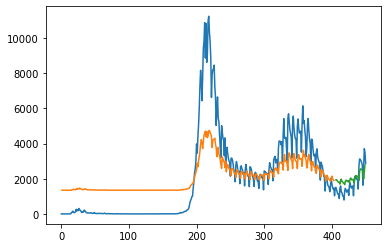

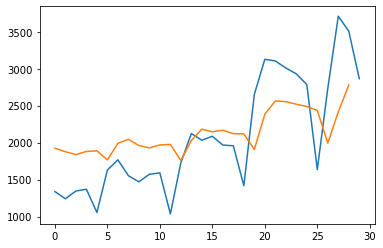

In [5]:
from tensorflow.keras.layers import Flatten,Reshape
tf.random.set_seed(7)

# 2/3 資料為訓練資料， 1/3 資料為測試資料
train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# 產生 (X, Y) 資料集, Y 是下一期的確診數(reshape into X=t and Y=t+1)
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# 建立及訓練 GRU 模型
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(1, look_back)),
    LSTM(64, return_sequences=True, activation='selu'),
    Dense(64, activation='selu'),
    GRU(64, return_sequences=True, activation='selu'),
    GRU(64, return_sequences=False, activation='selu'),
    Dense(1, activation='tanh')
])

model.output_shape
#model.compile(loss='categorical_crossentropy', optimizer=opt)
#opt = keras.optimizers.Adam(learning_rate=0.0001)
sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd ,metrics=['mse'])


model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="taipei_gru_lstm.keras",
    save_weights_only=True,
    monitor='val_mse',
    mode='min',
    save_best_only=True)

model.summary()
history = model.fit(trainX, trainY,validation_data=(testX, testY), epochs=100, batch_size=10, verbose=1,callbacks=[model_checkpoint_callback])
model.save('taipei.h5')
# 預測
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict=trainPredict.reshape(-1, 1)
testPredict=testPredict.reshape(-1, 1)

# 回復預測資料值為原始數據的規模
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate 均方根誤差(root mean squared error)
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

#model = keras.models.load_model("jena_lstm.keras")
#print(f"Test MAE: {model.evaluate(testPredict)[1]:.2f}")

# 畫訓練資料趨勢圖
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# 畫測試資料趨勢圖
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


# 畫原始資料趨勢圖8
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.savefig('Taipei_plot.png') 
plt.show()

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
days=len(testPredictPlot)
plt.plot(scaler.inverse_transform(dataset[days-30:,:]))
plt.plot(testPredictPlot[days-30:,:])
plt.savefig("taipei_predict&real.png")
plt.show()

### Model4

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 64)             16896     
                                                                 
 dense_4 (Dense)             (None, 1, 4)              260       
                                                                 
 lstm_3 (LSTM)               (None, 1, 64)             17664     
                                                                 
 dense_5 (Dense)             (None, 1, 1)              65        
                                                                 
 gru_2 (GRU)                 (None, 1, 64)             12864     
                                                                 
 dense_6 (Dense)             (None, 1, 4)              260       
                                                                 
 gru_3 (GRU)                 (None, 1, 64)            

403/403 [==============================] - 1s 3ms/step - loss: 0.0473 - mse: 0.0473 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 52/100
403/403 [==============================] - 1s 3ms/step - loss: 0.0466 - mse: 0.0466 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 53/100
403/403 [==============================] - 1s 3ms/step - loss: 0.0463 - mse: 0.0463 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 54/100
403/403 [==============================] - 1s 3ms/step - loss: 0.0451 - mse: 0.0451 - val_loss: 0.0135 - val_mse: 0.0135
Epoch 55/100
403/403 [==============================] - 1s 3ms/step - loss: 0.0448 - mse: 0.0448 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 56/100
403/403 [==============================] - 1s 3ms/step - loss: 0.0438 - mse: 0.0438 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 57/100
403/403 [==============================] - 1s 3ms/step - loss: 0.0408 - mse: 0.0408 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 58/100
403/403 [==============================] - 1s 3ms/step - loss:

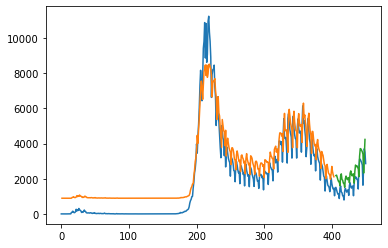

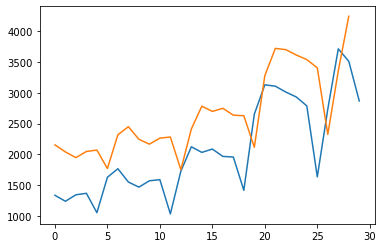

In [4]:
tf.random.set_seed(7)

# 2/3 資料為訓練資料， 1/3 資料為測試資料
train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# 產生 (X, Y) 資料集, Y 是下一期的確診數(reshape into X=t and Y=t+1)
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# 建立及訓練 GRU 模型
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(1, look_back)),
    Dense(4, activation='selu'),
    LSTM(64,return_sequences=True, activation='selu'),
    Dense(1, activation='tanh'),
    GRU(64,dropout=0.1,return_sequences=True, activation='selu'),
    Dense(4, activation='tanh'),
    GRU(64,dropout=0.1,return_sequences=True, activation='selu'),
    Dense(1, activation='tanh')
])

#model.compile(loss='categorical_crossentropy', optimizer=opt)
#opt = keras.optimizers.Adam(learning_rate=0.0001)
sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd ,metrics=['mse'])


model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="taipei_gru_lstm.keras",
    save_weights_only=True,
    monitor='val_mse',
    mode='min',
    save_best_only=True)

model.summary()
history = model.fit(trainX, trainY,validation_data=(testX, testY), epochs=100, batch_size=1, verbose=1,callbacks=[model_checkpoint_callback])
model.save('taipei.h5')
# 預測
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict=trainPredict.reshape(-1, 1)
testPredict=testPredict.reshape(-1, 1)
# 回復預測資料值為原始數據的規模
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate 均方根誤差(root mean squared error)
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

#model = keras.models.load_model("jena_lstm.keras")
#print(f"Test MAE: {model.evaluate(testPredict)[1]:.2f}")

# 畫訓練資料趨勢圖
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# 畫測試資料趨勢圖
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


# 畫原始資料趨勢圖
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.savefig('Taipei_plot.png') 
plt.show()

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
days=len(testPredictPlot)
plt.plot(scaler.inverse_transform(dataset[days-30:,:]))
plt.plot(testPredictPlot[days-30:,:])
plt.savefig("taipei_predict&real.png")
plt.show()